In [1]:
import os
import random

import itertools
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("grayscale")

from matplotlib import rcParams

from datetime import datetime

import statsmodels.api as sm

from pprint import pprint

from tqdm import tqdm

In [293]:
rcParams["figure.figsize"] = (18, 8)
rcParams["figure.dpi"] = 300
rcParams["axes.grid"] = True
rcParams["lines.linewidth"] = 0.5

In [4]:
! touch "./arima_results.csv"

In [5]:
MASTER_DIR = "/Users/tianyudu/Documents/UToronto/Course/ECO499/ugthesis"
LOG_FILE = "./arima_results.csv"
assert os.path.isfile(LOG_FILE)

In [6]:
df = pd.read_csv(
        MASTER_DIR + "/data/ready_to_use/returns_norm.csv",
        date_parser=lambda x: datetime.strptime(x, "%Y-%m-%d"),
        index_col=0
    )

In [7]:
print(len(df))
df.head()
df = df.asfreq("B")

5173


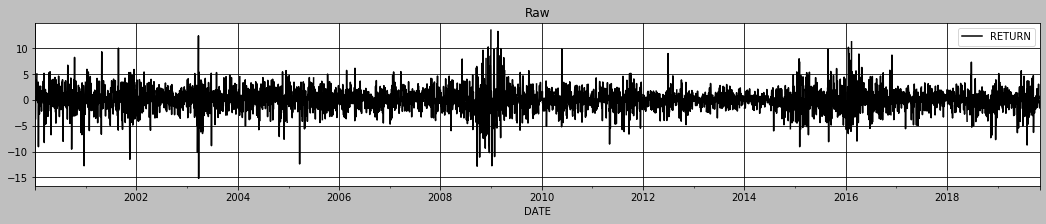

In [8]:
df.plot(figsize=(18, 3), grid=True)
plt.title("Raw")
plt.show()

In [9]:
arr = df.dropna().values.squeeze()
print(arr.shape)

(4978,)


In [15]:
# decomposition = sm.tsa.seasonal_decompose(arr, period=60, model="additive")
# fig = decomposition.plot()
# plt.show()

In [19]:
## Grid Searching for Parameters
# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
p = q = range(5)
d = range(2)
pdq_config = list(itertools.product(p, d, q))
seasonal_pdq_config = [
    (x[0], x[1], x[2], 10)
    for x in itertools.product(
        range(4),
        d,
        range(4))
]

random.shuffle(pdq_config)
random.shuffle(seasonal_pdq_config)

print(f"Total: {len(pdq_config) * len(seasonal_pdq_config)} configurations.")

Total: 1600 configurations.


In [21]:
candidates = list()

with open(LOG_FILE, "w") as log:
#     log.writelines(["p,d,q,sp,sd,sq,s,aic\n"])
    log.write("p,d,q,sp,sd,sq,s,aic\n")
    for i, param in enumerate(pdq_config):
        for j, param_seasonal in enumerate(seasonal_pdq_config):
            print(f"j / i")
            model = sm.tsa.statespace.SARIMAX(
                df,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=True,
                enforce_invertibility=True
            )
            results = model.fit()
            candidates.append({
                "pdq": param,
                "seasonal_pdq": param_seasonal,
                "aic":results.aic
            })
#             log.writelines([
#                 ",".join(str(x) for x in param + param_seasonal) + "," + str(results.aic) + "\n"
#             ])
            log.write(
                ",".join(str(x) for x in param + param_seasonal) + "," + str(results.aic) + "\n"
            )
#         print(f"ARIMA{param}x{param_seasonal} - AIC:{results.aic}")

j / i
j / i


KeyboardInterrupt: 

In [10]:
# # Grid Searching for Parameters
# p = q = range(10)
# d = [1]
# pdq_set = tuple(itertools.product(p, d, q))
# candidates = list()

# for (i, param) in enumerate(pdq_set):
#     progbar(i+1, len(pdq_set), max(len(pdq_set), 30))
#     try:
#         model = sm.tsa.statespace.SARIMAX(
#             df,
#             order=param,
#             enforce_stationarity=False,
#             enforce_invertibility=False,
#             freq="MS"
#         )
#         results = model.fit()
#         candidates.append({
#             "pdq": param,
#             "aic": results.aic
#         })
# #         print(f"ARIMA{param} - AIC:{results.aic}")
#     except:
#         continue

In [294]:
candidates.sort(key=lambda x:x["aic"])
print("Total num. of configs: ", len(candidates))
pprint(candidates[:5])
best_pdq, best_spdq = candidates[0]["pdq"], candidates[0]["seasonal_pdq"]

Total num. of configs:  2
[{'aic': 21783.617456712534, 'pdq': (3, 1, 3), 'seasonal_pdq': (0, 0, 1, 5)},
 {'aic': 21784.518167127662, 'pdq': (3, 1, 3), 'seasonal_pdq': (0, 0, 0, 5)}]


In [263]:
best_tqd = (3, 1, 3)
best_spdq = (1, 0, 1, 6)

In [264]:
# Fitting Seasonal ARIMA
model = sm.tsa.statespace.SARIMAX(
    df,
    order=best_pdq,
    seasonal_order=best_spdq,
    enforce_stationarity=True,
    enforce_invertibility=True
)

results = model.fit()

In [265]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              RETURN   No. Observations:                 5173
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 6)   Log Likelihood              -10875.008
Date:                             Fri, 21 Feb 2020   AIC                          21758.017
Time:                                     22:37:58   BIC                          21784.222
Sample:                                 01-04-2000   HQIC                         21767.185
                                      - 10-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0439      0.010     -4.527      0.000      -0.063      -0.025
ar.S.L6       -0.0782      

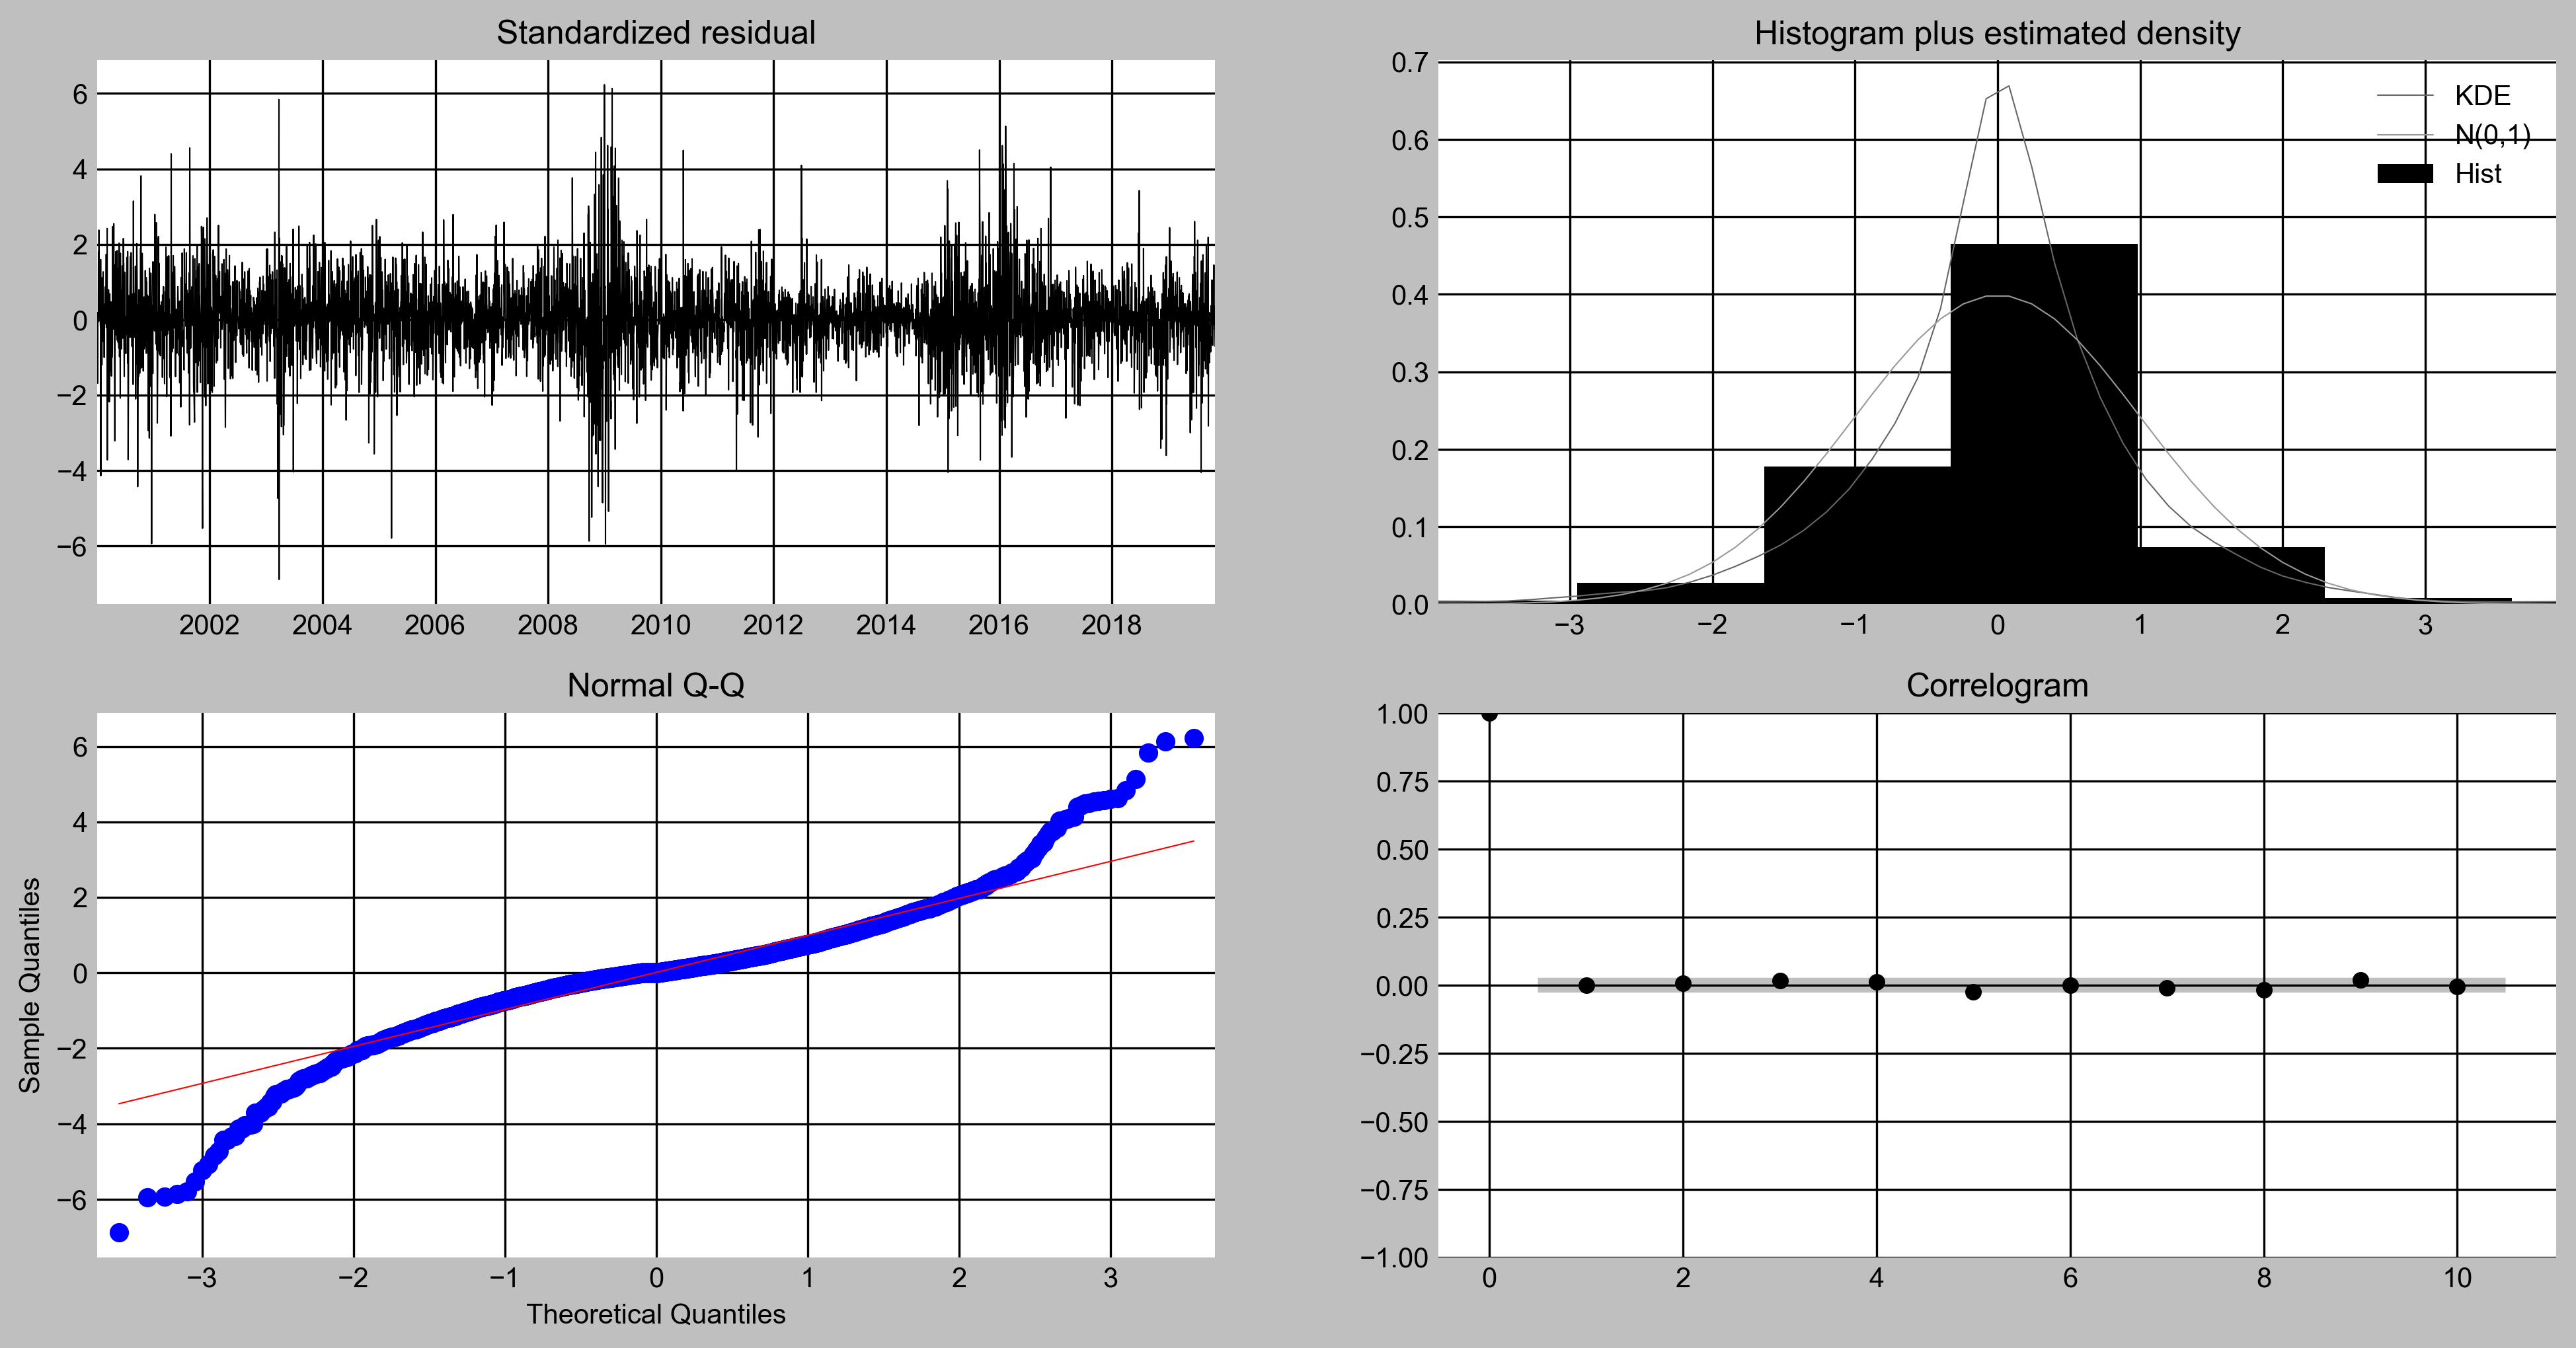

In [266]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [267]:
pred = results.get_prediction(start=pd.to_datetime("2000-01-05"), dynamic=False, conf_int=0.99)
pred_ci = pred.conf_int()
pred_ci.columns

Index(['lower RETURN', 'upper RETURN'], dtype='object')

In [268]:
col = "RETURN"
mask = lambda x: x[("2019-01-01" <= x.index) & (x.index <= "2019-10-31")]
mask(df)

,RETURN
DATE,
2019-01-01,NaN
2019-01-02,0.507353
2019-01-03,1.308610
2019-01-04,1.774445
2019-01-07,0.354059
...,...
2019-10-25,0.728051
2019-10-28,-0.547045
2019-10-29,-0.468723


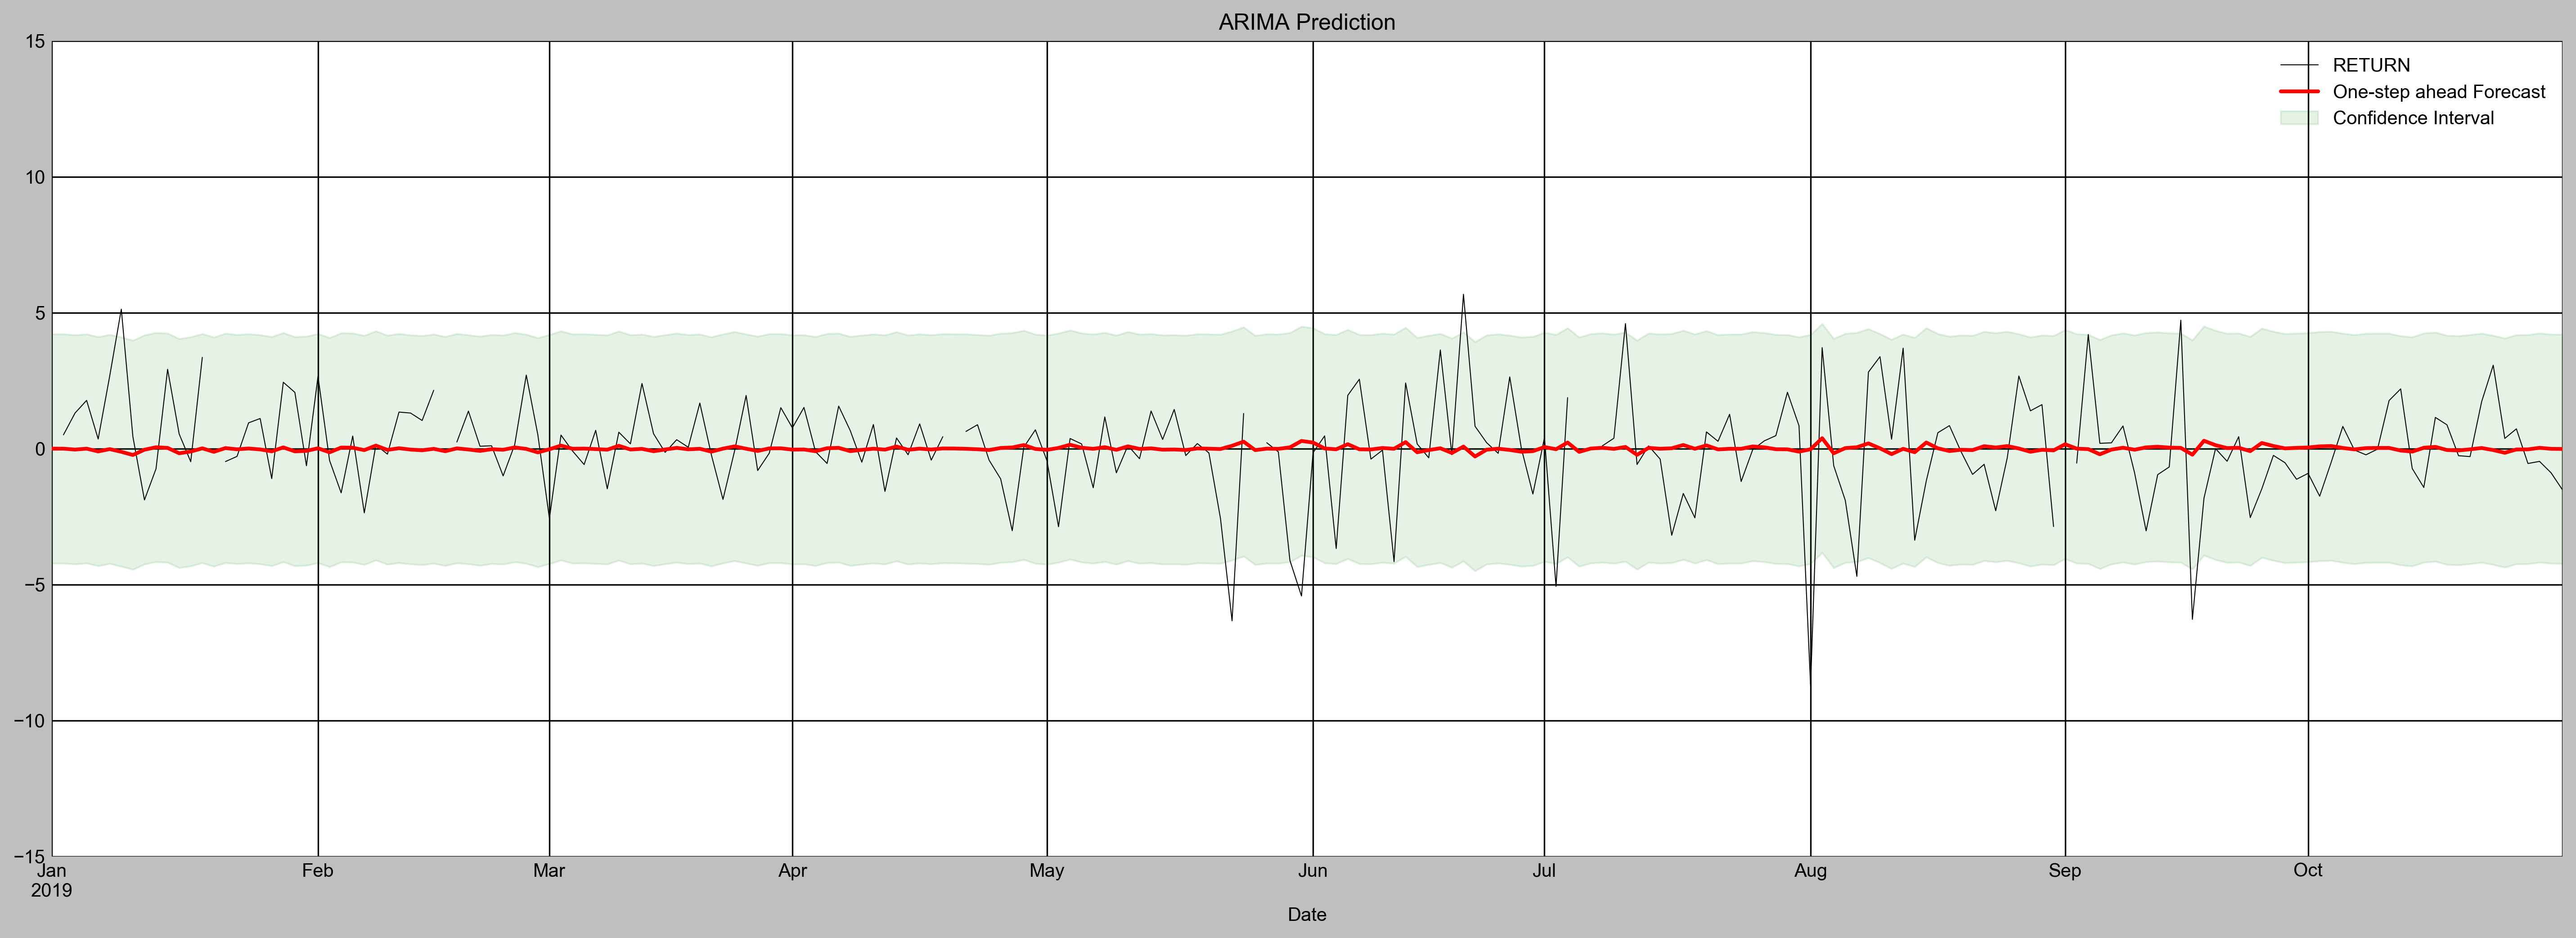

In [269]:
rcParams["figure.figsize"] = (24, 8)
ax = mask(df).plot(label="observed", alpha=1.)
mask(pred.predicted_mean).plot(ax=ax, label="One-step ahead Forecast", alpha=1.0, linewidth=2.0, color="red")
ax.fill_between(
    mask(pred_ci).index,
    mask(pred_ci[f"lower {col}"]),
    mask(pred_ci[f"upper {col}"]),
    color="green",
    alpha=0.1,
    label="Confidence Interval"
)
ax.set_ylim(-15, 15)
ax.set_xlabel("Date")
# ax.set_ylabel("UNRATE Raw Value")
plt.title("ARIMA Prediction")
plt.legend()
plt.show()

In [215]:
predicted = pred.predicted_mean.values
observed = np.squeeze(df["2000-01-04":].values)
rmse = np.sqrt(np.mean(
    (predicted - observed) ** 2
))
print(rmse)

ValueError: operands could not be broadcast together with shapes (5172,) (5173,) 

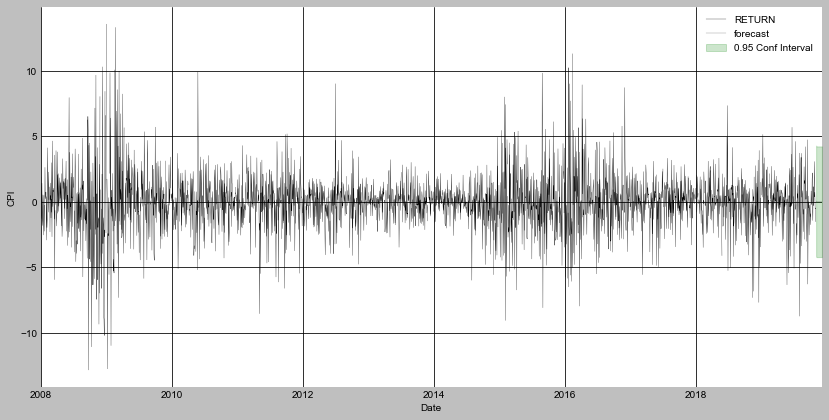

In [122]:
# Forecasting
alpha = 0.05
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int(alpha=alpha)

ax = df["2008-01-01":].plot(
    label="observed", figsize=(14, 7)
)
pred_uc.predicted_mean.plot(ax=ax, label="forecast")
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],  # Lower CI
    pred_ci.iloc[:, 1],  # Upper CI
    color="green",
    alpha=0.2,
    label=f"{1-alpha} Conf Interval"
)
ax.set_xlabel("Date")
ax.set_ylabel("CPI")

plt.legend()
plt.show()